<a href="https://colab.research.google.com/github/TirendazAcademy/NLP-with-Transformers/blob/main/Text-Analysis-with-Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis with Transformers using the Emotion Dataset
Text classification is a machine learning technique that uses to predict categories of open-ended text. Text classification is one of the most common tasks in NLP, allowing you to organize, structure and categorize almost any type of text from documents, medical research, files and anywhere on the web.

In this notebook, we'll analyze feedback from customers with the Twitter dataset, called the emotion dataset. We’ll overcome this task using a variant of BERT called DistilBERT. The main advantage of this model is that it achieves comparable performance to BERT, while being significantly smaller and more efficient. Let's start with installing the necessary libraries.

In [ ]:
!pip install datasets

# Loadind Dataset
To create our emotion detector, we’ll use the emotions dataset consisting of  English Twitter messages. This dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise. 

Given a tweet, our goal is to train a model that can classify it into one of these emotions. We'll use Datasets to download the data from the Hugging Face Hub.

In [2]:
from datasets import load_dataset
emotions = load_dataset("emotion")
emotions

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

# Data Preprocessing

As you can see, it is similar to a Python dictionary, with each key corresponding to a different split. This allows us to use the usual dictionary syntax to access an individual split:

In [3]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

This object is an instance of the Dataset class. Datasets are in a typed column format, which is more memory efficient than native Python.

Let's take a look at the first examples of this object.

In [4]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

Next, let's take a look at the names of columns in the object and the shape of the train set. 

In [5]:
print("The names of the columns: ", train_ds.column_names)
print("The shape of the train set: ", train_ds.shape)

The names of the columns:  ['text', 'label']
The shape of the train set:  (16000, 2)


Let's take a look at the data types in the train dataset.

In [6]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


## How to load a dataset not on the hub?

You may want to work with data stored on your laptop or on a remote server in your organization. Datasets allows you to handle local and remote datasets. Let's first download the emotion dataset and then load this dataset in our runtime.

In [8]:
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
!wget {dataset_url}
!head -n 1 train.txt

--2022-11-30 15:21:20--  https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/1pzkadrvffbqw6o/train.txt [following]
--2022-11-30 15:21:20--  https://www.dropbox.com/s/raw/1pzkadrvffbqw6o/train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc063bf9b7d4fd73c72041033e7d.dl.dropboxusercontent.com/cd/0/inline/BxsBUoDU_CjhmZiLKciL4xkvHlE-1Gf-XGvMjS8Mz7keqxA0tCA1ryAA-wdYTEx-xedgL8Zy_L7V46ERqKvwZOZ9MII0RChQyDK84BiAueoef2knY-lW01kFt_E-gCx_5U8_DuVWsXeKAMXvXYLryr-K3HSPflUh8EvXZZXdqz0n5Q/file# [following]
--2022-11-30 15:21:21--  https://uc063bf9b7d4fd73c72041033e7d.dl.dropboxusercontent.com/cd/0/inline/BxsBUoDU_CjhmZiLKciL4xkvHlE-1Gf-XGvMjS8Mz7keqxA0tCA1ryAA-wdYTEx-xedgL8Zy_L7V46ERqKvwZOZ9M

As you can see, the dataset is in csv format. Let's load the dataset locally by using the csv script with the `data_files` argument.

In [10]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";",  names=["text", "label"])
emotions_local

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

You can also directly load the dataseti from source.

In [11]:
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", names=["text", "label"])
emotions_remote

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a70389bc6b0a03f2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

## From Datasets to DataFrames

If you are familiar with Pandas for preprocessing and visualizing the dataset, you can convert the dataset to DataFrame with the `set_format()` method. Keep in mind that this does not change the underlying data format and you can switch to another format later if you want:

In [12]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


As you can see the labels represent numbers. You can also add labels corresponding to the numbers with the `int2str()` method.

In [13]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Understanding the Dataset

Let's take a look at the class distribution:

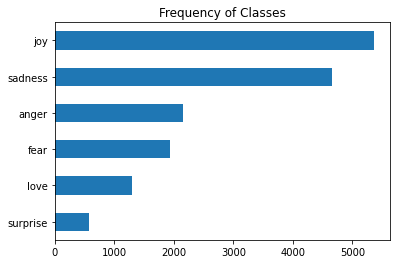

In [14]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

The dataset is heavily imbalanced; the joy and sadness classes appear frequently, whereas love and surprise are about 5–10 times rarer. You can overcome this problem with the [`Imbalanced-learn library`](https://imbalanced-learn.org/stable/). 

Transformer models have a maximum input sequence length that is referred to as the maximum context size. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. Let's take a look at the sequence lenghts of tweets.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


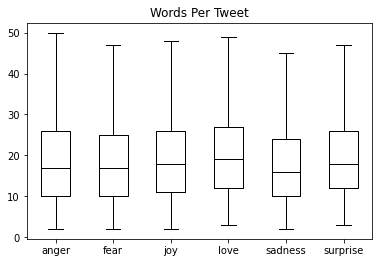

In [15]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

As you can see taht most tweets are around 15 words long and the longest tweets are well below DistilBERT’s maximum context size. 

Let’s now show how we can convert these raw texts into a format suitable for ​nlpt_pin01⁠ Transformers! First, let’s also reset the output format of our dataset since we don’t need the DataFrame format anymore:

In [16]:
emotions.reset_format()

## From Text to Tokens
Transformer models cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model.

To perform tokenization you can use `from_pretrained()` method in the `AutoTokenizer` class. This class let you quickly load the tokenizer associated with a pretrained model. 

In [7]:
!pip install transformers
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.4 MB/s 
     |████████████████████████████████| 7.6 MB 46.5 MB/s 


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

The AutoTokenizer class automatically retrieve the model’s configuration, pretrained weights, or vocabulary from the name of the checkpoint.

Let's tokenize the whole dataset the `map()` method. The first thing we need is a processing function to tokenize our examples with:

In [8]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Here [101] and [102] denote [CLS] and [SEP], respectively, which denote the beginning and end of the sequence. Once we’ve defined a processing function, we can apply it across all the splits in the corpus in a single line of code:

In [9]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

By default, the map() method operates individually on every example in the corpus, so setting batched=True will encode the tweets in batches. Because we’ve set batch_size=None, our tokenize() function will be applied on the full dataset as a single batch. This provides that the input tensors and attention masks have the same shape globally, 

In [11]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

# Training a Text Classifier